In [196]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import scipy
from scipy.spatial.transform import Rotation as R

In [197]:
cart_df = pd.read_csv("..//wheel_cart_teensy.csv")

In [198]:
cart_df

,sys_time,e_fr,e_fl,e_rr,e_rl
0,2022-06-09 18:15:44.226167,-470,-1722,897,-6141
1,2022-06-09 18:15:44.396577,-470,-1722,897,-6141
2,2022-06-09 18:15:44.396577,-470,-1722,897,-6141
3,2022-06-09 18:15:44.397077,-470,-1722,897,-6141
4,2022-06-09 18:15:44.397077,-470,-1722,897,-6141
...,...,...,...,...,...
7873,2022-06-09 18:16:55.309908,8880,-7424,-6659,2448
7874,2022-06-09 18:16:55.310408,8880,-7424,-6659,2448
7875,2022-06-09 18:16:55.310408,8880,-7424,-6659,2448
7876,2022-06-09 18:16:55.310908,8880,-7424,-6659,2448


In [199]:
mc = pd.read_csv("..//mocap_data.csv", skiprows=6)

In [200]:
st_time_mc = "2022-06-09 06.15.20.583 PM"
mc_dt = datetime.strptime(st_time_mc, "%Y-%m-%d %I.%M.%S.%f %p")
mc_dt

datetime.datetime(2022, 6, 9, 18, 15, 20, 583000)

In [201]:
mc = mc.rename(columns={"Time (Seconds)":"seconds"})

In [202]:
_t = []
for i in list(mc["seconds"]):
    _t.append(mc_dt + timedelta(0,i))

mc["time"] = _t

In [203]:
mc

,Frame,seconds,center_x,center_y,center_z,org_x,org_y,org_z,xvec_x,xvec_y,xvec_z,zvec_x,zvec_y,zvec_z,time
0,0,0.00,0.003236,0.067702,-0.139123,-0.037691,0.065555,-0.203663,0.040555,0.064554,-0.203653,-0.039944,0.067606,-0.075845,2022-06-09 18:15:20.583
1,1,0.01,0.003246,0.067713,-0.139121,-0.037848,0.065173,-0.203597,0.040547,0.064546,-0.203648,-0.039949,0.067603,-0.075850,2022-06-09 18:15:20.593
2,2,0.02,0.003251,0.067696,-0.139129,-0.037697,0.065541,-0.203672,0.040666,0.064750,-0.203737,-0.039946,0.067590,-0.075851,2022-06-09 18:15:20.603
3,3,0.03,0.003240,0.067709,-0.139121,-0.037702,0.065550,-0.203678,0.040547,0.064553,-0.203648,-0.039948,0.067594,-0.075842,2022-06-09 18:15:20.613
4,4,0.04,0.003244,0.067717,-0.139121,-0.037855,0.065084,-0.203598,0.040558,0.064545,-0.203640,-0.039948,0.067595,-0.075849,2022-06-09 18:15:20.623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9254,9254,92.54,0.039232,0.071813,0.051145,-0.001136,0.068630,-0.014420,0.077186,0.068300,-0.012831,-0.005280,0.070822,0.113676,2022-06-09 18:16:53.123
9255,9255,92.55,0.039225,0.071808,0.051153,-0.001097,0.068626,-0.014390,0.077171,0.068299,-0.012826,-0.005282,0.070847,0.113693,2022-06-09 18:16:53.133
9256,9256,92.56,0.039230,0.071796,0.051143,-0.001104,0.068610,-0.014394,0.077188,0.068304,-0.012824,-0.005281,0.070832,0.113681,2022-06-09 18:16:53.143
9257,9257,92.57,0.039229,0.071813,0.051151,-0.001111,0.068638,-0.014422,0.077169,0.068288,-0.012831,-0.005277,0.070810,0.113667,2022-06-09 18:16:53.153


In [204]:
"""getting initial values of motion capture data"""

marker_cen = np.array(mc[["center_x", "center_y", "center_z"]].iloc[0]).T
marker_xvec = np.array(mc[["xvec_x", "xvec_y", "xvec_z"]].iloc[0]).T
marker_zvec = np.array(mc[["zvec_x", "zvec_y", "zvec_z"]].iloc[0]).T
marker_org = np.array(mc[["org_x", "org_y", "org_z"]].iloc[0]).T

In [205]:
v1 = marker_xvec - marker_org #v1
v2 = marker_zvec - marker_org #v2

v1 = v1.reshape(3,1)
v2 = v2.reshape(3,1)
v3 = marker_org.reshape(3,1)

In [206]:
def calculate_rotmat(xdir,zdir,org):
    """
    this function calculates rotation matrix
    """
    v1 = xdir - org #v1
    v2 = zdir - org #v2

    vxnorm = v1/np.linalg.norm(v1)

    vzcap = v2 - (vxnorm.T @ v2) * vxnorm
    vznorm = vzcap/ np.linalg.norm(vzcap)

    vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3,1)
    rotMat = np.hstack((vxnorm, vynorm, vznorm))
    return rotMat

In [207]:
"""getting initial rot mat in mc data"""

rot_mat = calculate_rotmat(v1, v2, v3)
rot_mat

array([[ 0.47588045,  0.27741993, -0.83461127],
       [-0.27318888,  0.9486361 ,  0.15955369],
       [ 0.83600576,  0.15207804,  0.52722542]])

In [208]:
temp_list = []
for i in range(len(mc["xvec_x"])):
    center_val =  np.array(mc[["center_x", "center_y", "center_z"]].iloc[i])
    center_val = center_val.reshape(3,1)
    transformed_center = rot_mat.T @ center_val + v3
    transformed_center = transformed_center.T[0]
    temp_list.append(transformed_center)
mc[["cen_x", "cen_y", "cen_z"]] = temp_list

In [209]:
mc

,Frame,seconds,center_x,center_y,center_z,org_x,org_y,org_z,xvec_x,xvec_y,xvec_z,zvec_x,zvec_y,zvec_z,time,cen_x,cen_y,cen_z
0,0,0.00,0.003236,0.067702,-0.139123,-0.037691,0.065555,-0.203663,0.040555,0.064554,-0.203653,-0.039944,0.067606,-0.075845,2022-06-09 18:15:20.583,-0.170954,0.109520,-0.268911
1,1,0.01,0.003246,0.067713,-0.139121,-0.037848,0.065173,-0.203597,0.040547,0.064546,-0.203648,-0.039949,0.067603,-0.075850,2022-06-09 18:15:20.593,-0.170951,0.109533,-0.268916
2,2,0.02,0.003251,0.067696,-0.139129,-0.037697,0.065541,-0.203672,0.040666,0.064750,-0.203737,-0.039946,0.067590,-0.075851,2022-06-09 18:15:20.603,-0.170950,0.109517,-0.268928
3,3,0.03,0.003240,0.067709,-0.139121,-0.037702,0.065550,-0.203678,0.040547,0.064553,-0.203648,-0.039948,0.067594,-0.075842,2022-06-09 18:15:20.613,-0.170952,0.109528,-0.268912
4,4,0.04,0.003244,0.067717,-0.139121,-0.037855,0.065084,-0.203598,0.040558,0.064545,-0.203640,-0.039948,0.067595,-0.075849,2022-06-09 18:15:20.623,-0.170953,0.109536,-0.268914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9254,9254,92.54,0.039232,0.071813,0.051145,-0.001136,0.068630,-0.014420,0.077186,0.068300,-0.012831,-0.005280,0.070822,0.113676,2022-06-09 18:16:53.123,0.004118,0.152341,-0.197983
9255,9255,92.55,0.039225,0.071808,0.051153,-0.001097,0.068626,-0.014390,0.077171,0.068299,-0.012826,-0.005282,0.070847,0.113693,2022-06-09 18:16:53.133,0.004122,0.152336,-0.197974
9256,9256,92.56,0.039230,0.071796,0.051143,-0.001104,0.068610,-0.014394,0.077188,0.068304,-0.012824,-0.005281,0.070832,0.113681,2022-06-09 18:16:53.143,0.004120,0.152324,-0.197986
9257,9257,92.57,0.039229,0.071813,0.051151,-0.001111,0.068638,-0.014422,0.077169,0.068288,-0.012831,-0.005277,0.070810,0.113667,2022-06-09 18:16:53.153,0.004121,0.152341,-0.197978


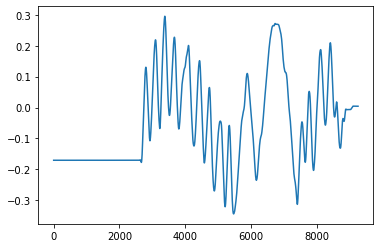

In [210]:
plt.plot(mc["cen_x"])

In [211]:
"""resetting cart values to zero"""
cart_df["e_fr"] = cart_df["e_fr"]- cart_df["e_fr"].iloc[0]
cart_df["e_fl"] = cart_df["e_fl"]- cart_df["e_fl"].iloc[0]
cart_df["e_rr"] = cart_df["e_rr"]- cart_df["e_rr"].iloc[0]
cart_df["e_rl"] = cart_df["e_rl"]- cart_df["e_rl"].iloc[0]

cart_df

,sys_time,e_fr,e_fl,e_rr,e_rl
0,2022-06-09 18:15:44.226167,0,0,0,0
1,2022-06-09 18:15:44.396577,0,0,0,0
2,2022-06-09 18:15:44.396577,0,0,0,0
3,2022-06-09 18:15:44.397077,0,0,0,0
4,2022-06-09 18:15:44.397077,0,0,0,0
...,...,...,...,...,...
7873,2022-06-09 18:16:55.309908,9350,-5702,-7556,8589
7874,2022-06-09 18:16:55.310408,9350,-5702,-7556,8589
7875,2022-06-09 18:16:55.310408,9350,-5702,-7556,8589
7876,2022-06-09 18:16:55.310908,9350,-5702,-7556,8589


In [212]:
mils = np.arange(0, len(cart_df["e_fr"])*10, 10)
cart_df["mils"] = mils

These are the parameters of the cart

Diameter = 95 mm
radius = 47.5
wheel thickness = 45 mm
gap between wheel and chassis = 6.5 mm
angle between center of chassis and z-dir vector = 51.21 degrees
distance between the wheel = 158 mm
distance between the wheel and the center of the robot = 101.36 (li)


In [213]:
"""circumfrence of the wheel"""

cir_wheel = 2*np.pi*47.5
cir_wheel
radius = 47.5

lx = 79 #half of the distance between the wheels
ly = 122.5/2

The encoder values will give 4000 values per revolution
360/4000 = 0.09 degrees per encoder rotation value

In [214]:
""" angular velocity"""
cart_df["av_fr"] = (cart_df["e_fr"]*0.09).diff()/10
cart_df["av_fl"] = (cart_df["e_fl"]*0.09).diff()/10
cart_df["av_rr"] = (cart_df["e_rr"]*0.09).diff()/10
cart_df["av_rl"] = (cart_df["e_rl"]*0.09).diff()/10
cart_df['av_fr'] = cart_df["av_fr"].fillna(0)
cart_df['av_fl'] = cart_df["av_fl"].fillna(0)
cart_df['av_rr'] = cart_df["av_rr"].fillna(0)
cart_df['av_rl'] = cart_df["av_rl"].fillna(0)
cart_df["av_fl"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7873    0.0
7874    0.0
7875    0.0
7876    0.0
7877    0.0
Name: av_fl, Length: 7878, dtype: float64

In [215]:
"""finding vx, vy, w"""

cart_df["vx"] = (cart_df["av_fr"] + cart_df["av_fl"] + cart_df["av_rl"] + cart_df["av_rr"])*(radius/4)
cart_df["vy"] = (- cart_df["av_fr"] + cart_df["av_fl"] + cart_df["av_rl"] - cart_df["av_rr"])*(radius/4)
cart_df["w"] = (- cart_df["av_fr"] + cart_df["av_fl"] - cart_df["av_rl"] + cart_df["av_rr"])*(radius/(4*(lx + ly)))

In [216]:
cart_df["vx"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7873    0.0
7874    0.0
7875    0.0
7876    0.0
7877    0.0
Name: vx, Length: 7878, dtype: float64

In [217]:
"""calculating displacement
s=(1/2)* (v+u)t
v = current velocity
u = initial velocity
t = time
s = displacement
"""
_xval = []
_yval = []
for i in range(len(cart_df["vx"])):
    _xval.append(0.5*(cart_df["vx"].iloc[i] + cart_df["vx"].iloc[0])*10)
    _yval.append(0.5*(cart_df["vy"].iloc[i] + cart_df["vy"].iloc[0])*10)
cart_df["x_val"] = _xval
cart_df["y_val"] = _yval

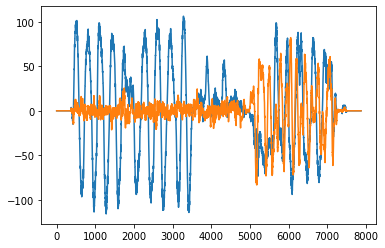

In [218]:
plt.plot(cart_df["x_val"])
plt.plot(cart_df["y_val"])

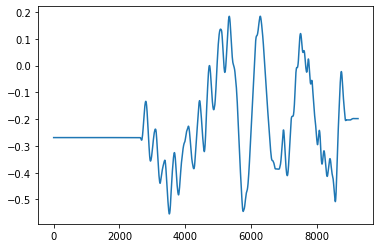

In [221]:
plt.plot(mc["cen_z"])